In [3]:
 !pip install -U tensorflow_datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.3
    Uninstalling tensorflow-datasets-4.8.3:
      Successfully uninstalled tensorflow-datasets-4.8.3


ModuleNotFoundError: ignored

In [4]:
import tensorflow_datasets as tfds

In [5]:
import tensorflow as tf
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt


In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [7]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

#metadata.features dictionary contains information about the features of the dataset, including the labels.

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [12]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("NUmber of Training examples: {}".format(num_train_examples))
print("Nimber of testing examples: {}".format(num_test_examples))

NUmber of Training examples: 60000
Nimber of testing examples: 10000


1. Each row is a separate image
2. Column 1 is the class label.
3. Remaining columns are pixel numbers (784 total).
4. Each value is the darkness of the pixel (1 to 255)

In [13]:
def normalize(images, labels):
  images = tf.cast(images,tf.float32)
  images /=255
  return images,labels

#normalizing them to a range of 0-1 can improve the convergence of the training algorithm.
#The function then returns the normalized images and corresponding labels as a tuple, which can be passed to the model for training or evaluation. 

In [14]:
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

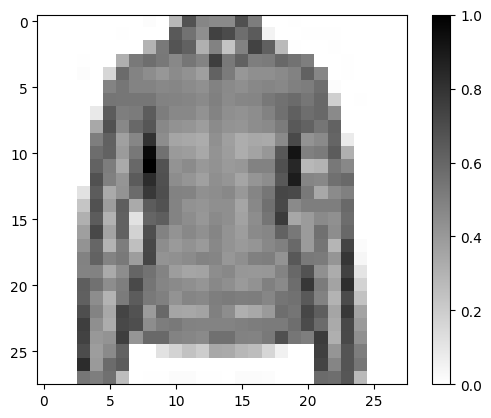

In [15]:
for image, label in test_dataset.take(1):
  break

image = image.numpy().reshape((28,28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

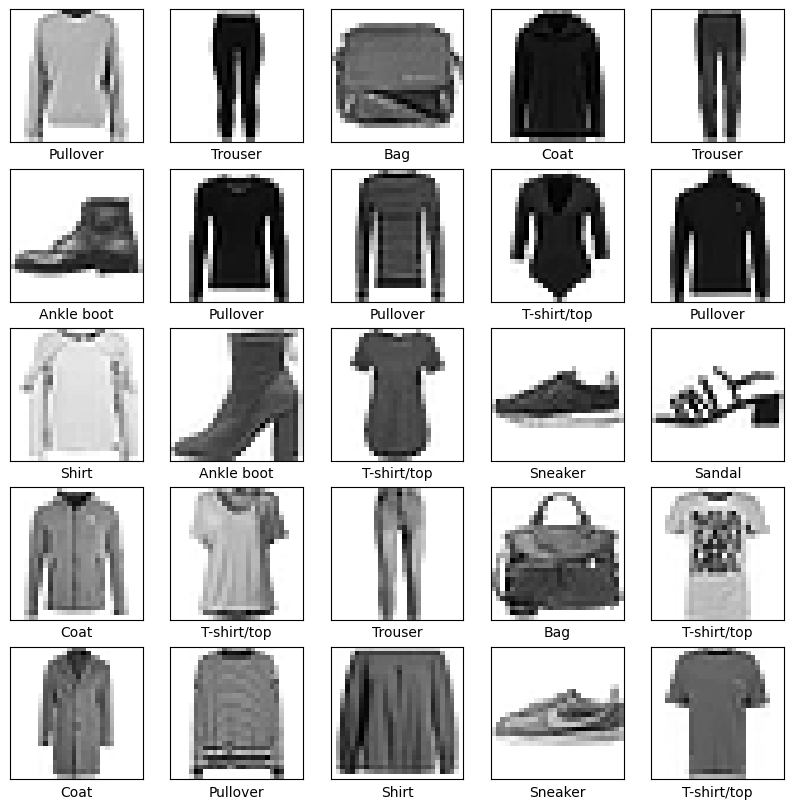

In [16]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image,cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()


## MODEL

In [18]:
#1. setup the layer

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape =(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [20]:
#2. compile the model
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'])

In [21]:
#3. train the model
     #1. we need to define the iterative behaviour for the train dataset:
     #2. train -- model.fit

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [22]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 12s 3ms/step - loss: 0.4944 - accuracy: 0.8266
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3719 - accuracy: 0.8661
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3298 - accuracy: 0.8797
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3118 - accuracy: 0.8862
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2932 - accuracy: 0.8917


## Evaluate Accuracy

In [23]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps= math.ceil(num_test_examples/32))
print("Accuracy on test dataset:",test_accuracy)

  7/313 [..............................] - ETA: 2s - loss: 0.4011 - accuracy: 0.8482  

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 2s 5ms/step - loss: 0.3538 - accuracy: 0.8709
Accuracy on test dataset: 0.8708999752998352


Explore

In [24]:
for test_images, test_labels in test_dataset.take(1):
  #convert the TensorFlow tensors test_images and test_labels into NumPy arrays.
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images) 
  #he conversion is being done to allow the test images and labels to be used with other Python libraries

1/1 [==============================] - 0s 76ms/step


In [25]:
predictions.shape

(32, 10)

In [30]:
predictions[0]

array([2.1268454e-05, 5.3329886e-06, 3.1609993e-02, 5.0861531e-06,
       8.7039149e-01, 1.0771453e-09, 9.7945638e-02, 2.1471948e-07,
       2.0916385e-05, 9.2282690e-08], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [31]:
np.argmax(predictions[0])

4

In [28]:
test_labels[0]

4

In [32]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

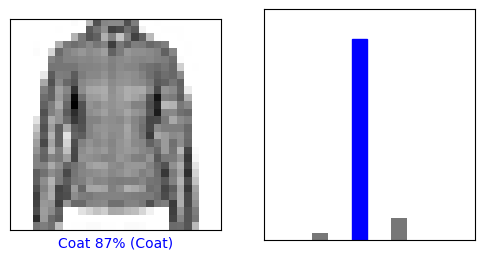

In [33]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

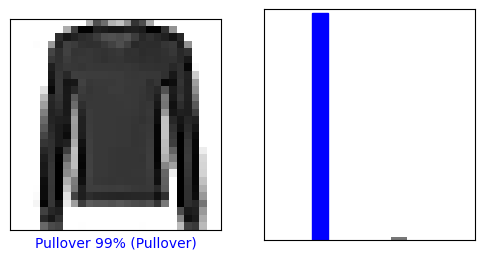

In [34]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

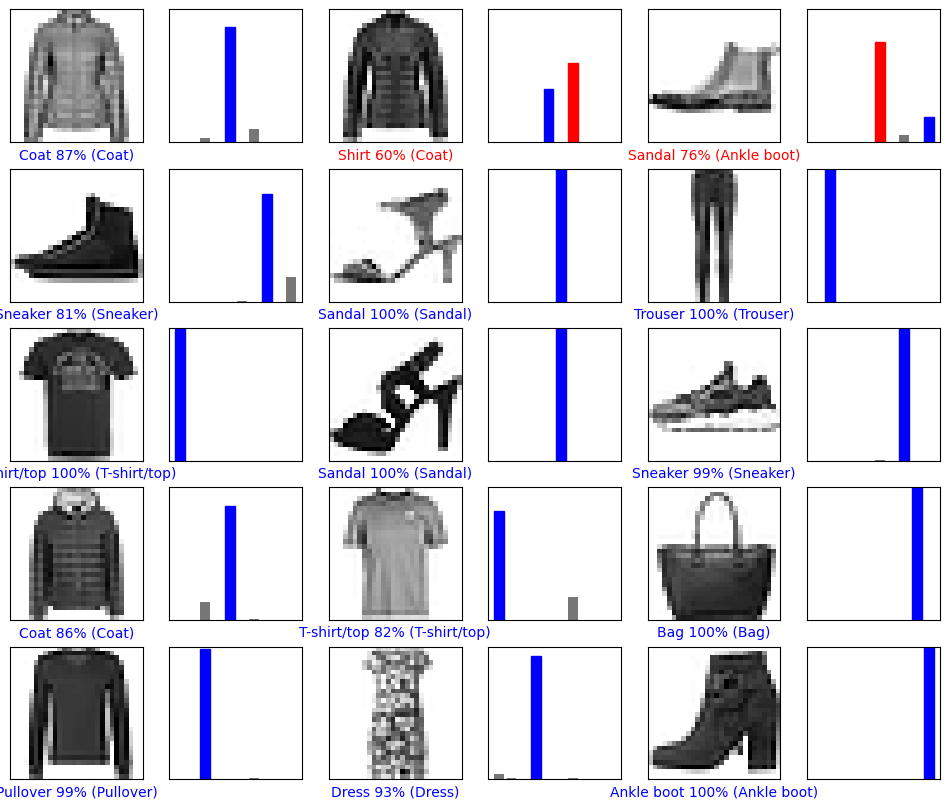

In [36]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows,2*num_cols, 2*i+2)
  plot_value_array(i,predictions, test_labels)

In [37]:
#take image
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [38]:
#add it to array
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [39]:
#predict

predictions_single = model.predict(img)
print(predictions_single)

1/1 [==============================] - 0s 47ms/step
[[2.1268437e-05 5.3329895e-06 3.1609986e-02 5.0861490e-06 8.7039161e-01
  1.0771454e-09 9.7945645e-02 2.1471971e-07 2.0916386e-05 9.2282534e-08]]


In [41]:
np.argmax(predictions_single[0])

4

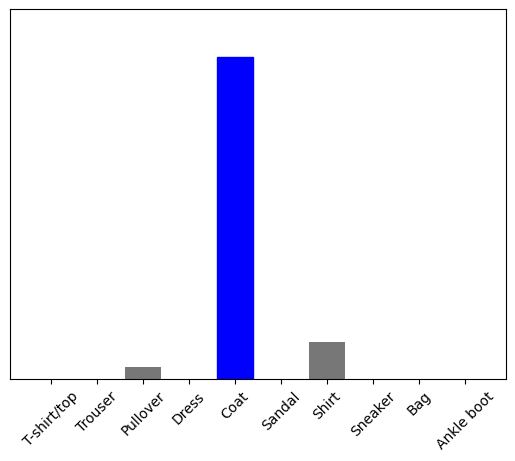

In [42]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

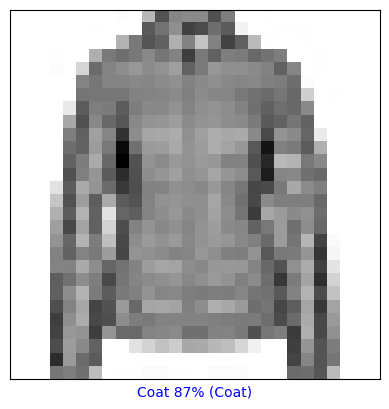

In [44]:
 plot_image(0, predictions_single, test_labels, test_images)